# Sistemas Inteligentes: Aprendizaje Automático

_Guillermo Facundo Colunga_

## Introducción

Para la práctica de aprendizaje automático se empleará el paquete caret de R para evaluar el mejor modelo que sea capaz de predecir el tipo de cáncer según la información de expresión de losgenes en distintas muestras de pacientes reales.

Para ello se evaluarán distintos paradigmas de clasificación: **árbol de decisión, vecinos más cercanos, redes neuronales y máquinas de vector soporte**. Y a continuación se evaluarán de forma individual y colectiva.


Para empezar a trabajar con el paquete `caret` debemos de cargarlo en R. También cargaremos el paquete `mlbench` y la librería `ggplot` para dibujar los gráficos coprrespondientes.

In [2]:
library(caret)
library(mlbench)
library(ggplot2)

Loading required package: lattice
Loading required package: ggplot2


## Carga de datos en R

Lo primero que debemos hacer es cargar los datos de las muestras en R. Para ello previamente hemos descargado y descomprimido los [datos](https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq) en el directorio `data`.

In [3]:
geneLevel <- read.csv('./data/data.csv',stringsAsFactors = F)
label <- read.csv('./data/labels.csv',stringsAsFactors = F)
tcga <- merge(geneLevel, label, sort = F)
tcga$X <- NULL

Los datos cargados contienen 20531 variables y 801 instancias. Nuestro ordenador no puede trabar con tantos datos así que emplearemos los números de nuestro identificador universitario para escoger 100 variables.

In [4]:
set.seed(236856) #Pon aquí los número de tu UO
tcga.filtered <- tcga[,c(sample(ncol(tcga)-1,100),ncol(tcga))]

A continuación seleccionamos el porcentaje de datos para entrenamiento y para la evaluación posterior. Como en este ejemplo tenemos una gran cantidad de datos seleccionaremos un 75% de los datos para entrenar nuestros modelos y un 25% para validarlo.

In [65]:
inTrain <- createDataPartition(
    ## indicamos la clase
    y = tcga.filtered$Class,
    
    ## el porcentaje de instancias para entrenamiento
    p = .75,
    
    ## controla el formato de salida
    list = FALSE
)

training <- tcga.filtered[ inTrain,]
testing <- tcga.filtered[-inTrain,]

Ahora, para simplificar el desarrollo seleccionaremos como nuestro método de control el de validación cruzada, yua que es el que mayor precisión nos da

In [67]:
# Usaremos el método cross-validation ya que es el que mayor precisión nos da.
ctrl <- trainControl(method="cv")

## Árbol de decisión

De acuerdo con wikipedia, un árbol de decisión es un mecanismo en el que dado un conjunto de datos se fabrican diagramas de construcciones lógicas, muy similares a los sistemas de predicción basados en reglas, que sirven para representar y categorizar una serie de condiciones que ocurren de forma sucesiva, para la resolución de un problema.

Tanto en teroría como en prácticas vimos distintos modelos de árboles de decisión, a continuación implementaremos los modelos J48, rpart y rpart2 para comparar su precisión para el problema dado.

### Modelo J48

In [71]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo con J48.
c4.5Fit <- train(
    Class ~ .,
    data = training,
    method = "J48",
    trControl = ctrl
)

c4.5Fit$results[rownames(c4.5Fit$bestTune),1:3]

,C,M,Accuracy
3,0.01,3,0.8338648


In [74]:
confusionMatrix(predict(c4.5Fit,testing), factor(testing$Class))$overall[1:4]

Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.8793970     0.8366677     0.8258839     0.9211776

### Modelo rpart

In [8]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo con rpart.
rpartFit <- train(
  Class ~ .,
  data = training,
  method = "rpart",
  trControl = ctrl,
  tuneLength = 6
)

rpartFit$results[rownames(rpartFit$bestTune),1:3]

cp,Accuracy,Kappa
0.00795756,0.8603015,0.8143999


In [9]:
confusionMatrix(predict(rpartFit,testing), factor(testing$Class))$overall[1:4]

Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.8542714     0.8069964     0.7974599     0.9001806

### Modelo rpart2

In [10]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo con rpart2.
rpart2Fit <- train(
  Class ~ .,
  data = training,
  method = "rpart2",
  trControl = ctrl,
  tuneLength = 6
) 

rpart2Fit$results[rownames(rpart2Fit$bestTune),1:3]

,maxdepth,Accuracy,Kappa
5,8,0.8619992,0.8164838


In [11]:
confusionMatrix(predict(rpart2Fit,testing), factor(testing$Class))$overall[1:4]

Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.8542714     0.8069964     0.7974599     0.9001806

De los modelos anteriores ( j48, rpart y rpart2 ) obtenemos que aquel que nos da una precisión mayor sobre los datos de test es el j48 con una precisión de 0.879396984924623.

## Vecinos más cercanos

In [12]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo con rpart2.
knnFitTraining <- train(
  Class ~ .,
  data = training,
  method = "knn",
  trControl = ctrl,
  tuneLength = 6
)
knnFitTraining$results[rownames(knnFitTraining$bestTune),1:3]

k,Accuracy,Kappa
5,0.9652056,0.9537264


In [13]:
confusionMatrix(predict(knnFitTraining,testing), factor(testing$Class))$overall[1:4]

Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.9698492     0.9602503     0.9355328     0.9888564

## Redes neuronales

Este es un método de clasificación no paramétrico, que estima el valor de la función de densidad de probabilidad o directamente la probabilidad a posteriori de que un elemento x pertenezca a la clase C a partir de la información proporcionada por el conjunto de prototipos. En el proceso de aprendizaje no se hace ninguna suposición acerca de la distribución de las variables predictoras.

In [14]:
ctrl <- trainControl( 
    method = "boot632", 
    number = 10
)

# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo
nn1LFit <- train(
    Class ~ .,
    data = training,
    method = "mlp",
    trControl = ctrl,
    tuneGrid = data.frame(size=seq(19,25,2))
)

# Mostramos el resultado obtenido tras realizar el entrenamiento.
nn1LFit

Multi-Layer Perceptron 

602 samples
100 predictors
  5 classes: 'BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD' 

No pre-processing
Resampling: Bootstrapped (10 reps) 
Summary of sample sizes: 602, 602, 602, 602, 602, 602, ... 
Resampling results across tuning parameters:

  size  Accuracy   Kappa
  19    0.3588939  0    
  21    0.3327008  0    
  23    0.3555623  0    
  25    0.3306315  0    

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was size = 19.

In [16]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo
nn2LFit <- train(
    Class ~ .,
    data = training,
    method = "mlpML",
    trControl = ctrl,
    tuneGrid = expand.grid(layer1=seq(9,13,2),layer2=seq(9,13,2),layer3=0)
)

# Mostramos el resultado obtenido tras realizar el entrenamiento.
nn2LFit

Warning message:
“At least one layer had zero units and were removed. The new structure is 9->9”Warning message:
“At least one layer had zero units and were removed. The new structure is 11->9”Warning message:
“At least one layer had zero units and were removed. The new structure is 13->9”Warning message:
“At least one layer had zero units and were removed. The new structure is 9->11”Warning message:
“At least one layer had zero units and were removed. The new structure is 11->11”Warning message:
“At least one layer had zero units and were removed. The new structure is 13->11”Warning message:
“At least one layer had zero units and were removed. The new structure is 9->13”Warning message:
“At least one layer had zero units and were removed. The new structure is 11->13”Warning message:
“At least one layer had zero units and were removed. The new structure is 13->13”Warning message:
“At least one layer had zero units and were removed. The new structure is 9->9”Warning message:
“At least o

Multi-Layer Perceptron, with multiple layers 

602 samples
100 predictors
  5 classes: 'BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD' 

No pre-processing
Resampling: Bootstrapped (10 reps) 
Summary of sample sizes: 602, 602, 602, 602, 602, 602, ... 
Resampling results across tuning parameters:

  layer1  layer2  Accuracy   Kappa
   9       9      0.3719919  0    
   9      11      0.3719919  0    
   9      13      0.3719919  0    
  11       9      0.3719919  0    
  11      11      0.3719919  0    
  11      13      0.3719919  0    
  13       9      0.3719919  0    
  13      11      0.3719919  0    
  13      13      0.3719919  0    

Tuning parameter 'layer3' was held constant at a value of 0
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were layer1 = 9, layer2 = 9 and layer3 = 0.

In [18]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo
nn3LFit <- train(
    Class ~ .,
    data = training,
    method = "mlpML",
    trControl = ctrl,
    tuneGrid = expand.grid(layer1=seq(9,11,2),layer2=seq(9,11,2),layer3=seq(9,11,2))
)

# Mostramos el resultado obtenido tras realizar el entrenamiento.
nn3LFit

Multi-Layer Perceptron, with multiple layers 

602 samples
100 predictors
  5 classes: 'BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD' 

No pre-processing
Resampling: Bootstrapped (10 reps) 
Summary of sample sizes: 602, 602, 602, 602, 602, 602, ... 
Resampling results across tuning parameters:

  layer1  layer2  layer3  Accuracy   Kappa
   9       9       9      0.3719919  0    
   9       9      11      0.3719919  0    
   9      11       9      0.3719919  0    
   9      11      11      0.3719919  0    
  11       9       9      0.3719919  0    
  11       9      11      0.3719919  0    
  11      11       9      0.3719919  0    
  11      11      11      0.3719919  0    

Accuracy was used to select the optimal model using the largest value.
The final values used for the model were layer1 = 9, layer2 = 9 and layer3 = 9.

In [19]:
nn2LFit$results[,1:4]

,layer1,layer2,layer3,Accuracy
9,9,9,0,0.3719919
7,9,11,0,0.3719919
8,9,13,0,0.3719919
3,11,9,0,0.3719919
1,11,11,0,0.3719919
2,11,13,0,0.3719919
6,13,9,0,0.3719919
4,13,11,0,0.3719919
5,13,13,0,0.3719919


In [20]:
nn3LFit$results[,1:4]

,layer1,layer2,layer3,Accuracy
8,9,9,9,0.3719919
7,9,9,11,0.3719919
6,9,11,9,0.3719919
5,9,11,11,0.3719919
4,11,9,9,0.3719919
3,11,9,11,0.3719919
2,11,11,9,0.3719919
1,11,11,11,0.3719919


In [15]:
set.seed(236856) 
nn1LFit1000Iter <- train(
    Class ~ .,
    data = training,
    method = "mlp",
    trControl = ctrl,
    tuneGrid = data.frame(size=21),
    maxit = 1000 
)

set.seed(236856)
nn2LFit1300Iter <- train(
    Class ~ .,
    data = training,
    method = "mlpML",
    trControl = ctrl,
    tuneGrid = expand.grid(layer1=13,layer2=11,layer3=0), maxit = 1300
)

set.seed(236856)
nn3LFit1750Iter <- train(
    Class ~ .,
    data = training,
    method = "mlpML",
    trControl = ctrl,
    tuneGrid = expand.grid(layer1=11,layer2=11,layer3=11), maxit = 1750
)

Warning message:
“At least one layer had zero units and were removed. The new structure is 13->11”Warning message:
“At least one layer had zero units and were removed. The new structure is 13->11”Warning message:
“At least one layer had zero units and were removed. The new structure is 13->11”Warning message:
“At least one layer had zero units and were removed. The new structure is 13->11”Warning message:
“At least one layer had zero units and were removed. The new structure is 13->11”Warning message:
“At least one layer had zero units and were removed. The new structure is 13->11”Warning message:
“At least one layer had zero units and were removed. The new structure is 13->11”Warning message:
“At least one layer had zero units and were removed. The new structure is 13->11”Warning message:
“At least one layer had zero units and were removed. The new structure is 13->11”Warning message:
“At least one layer had zero units and were removed. The new structure is 13->11”Warning message:
“At

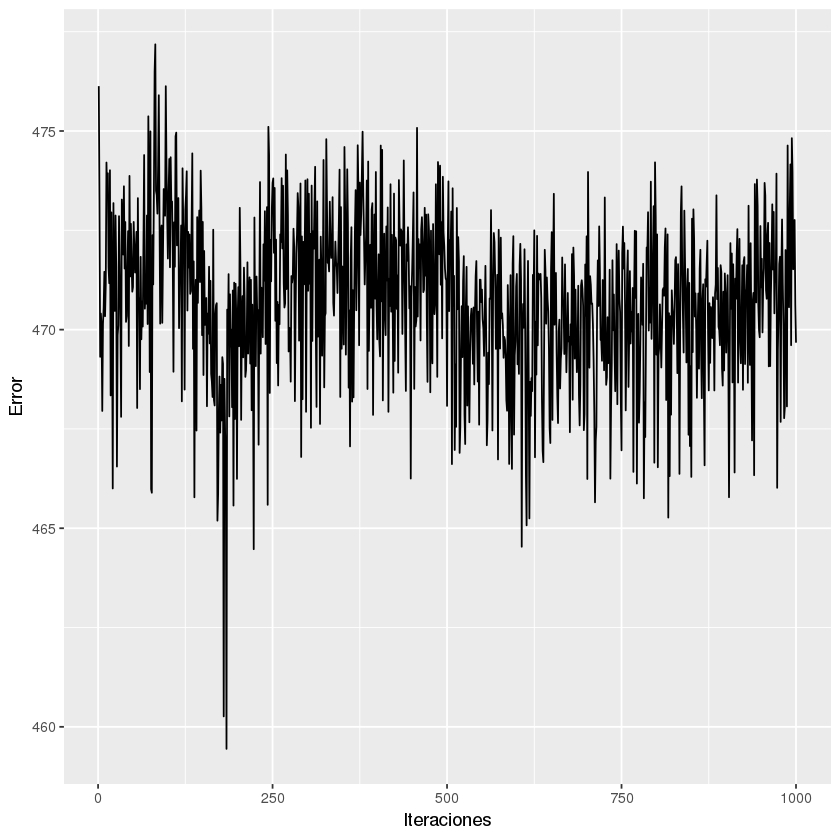

In [16]:
ggplot() + geom_line(aes(x=1:length(nn1LFit1000Iter$finalModel$IterativeFitError), y=nn1LFit1000Iter$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error")

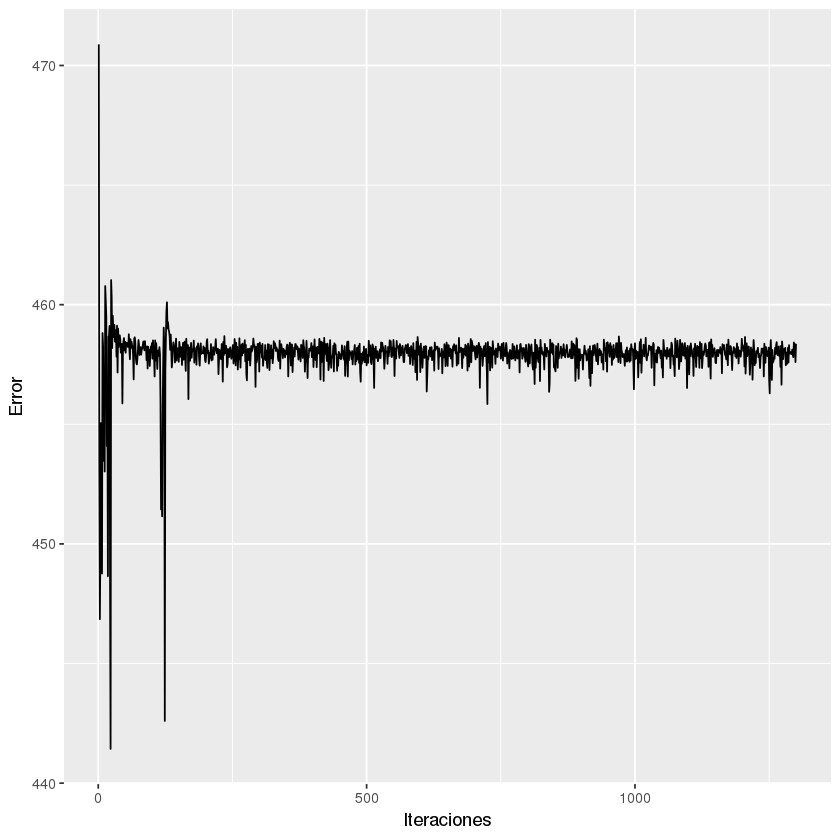

In [17]:
ggplot() + geom_line(aes(x=1:length(nn2LFit1300Iter$finalModel$IterativeFitError), y=nn2LFit1300Iter$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error")

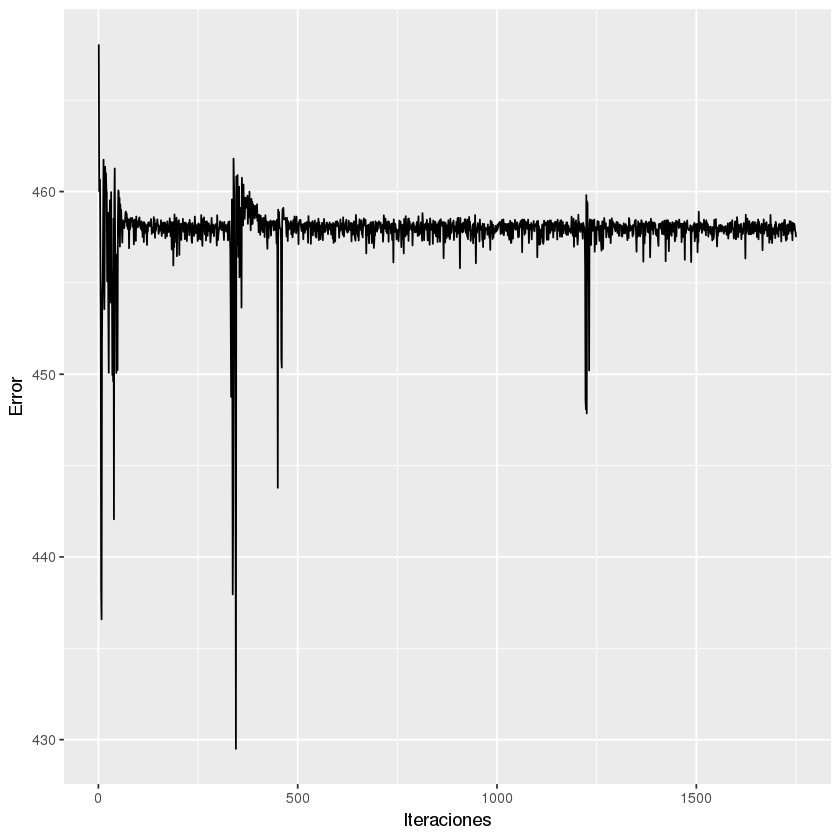

In [18]:
ggplot() + geom_line(aes(x=1:length(nn3LFit1750Iter$finalModel$IterativeFitError), y=nn3LFit1750Iter$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error")

In [23]:
nn1LFit1000Iter$results[,1:2]

size,Accuracy
21,0.289527


In [24]:
nn2LFit1300Iter$results[,1:4]

layer1,layer2,layer3,Accuracy
13,11,0,0.3719919


In [25]:
nn3LFit1750Iter$results[,1:4]

layer1,layer2,layer3,Accuracy
11,11,11,0.3719919


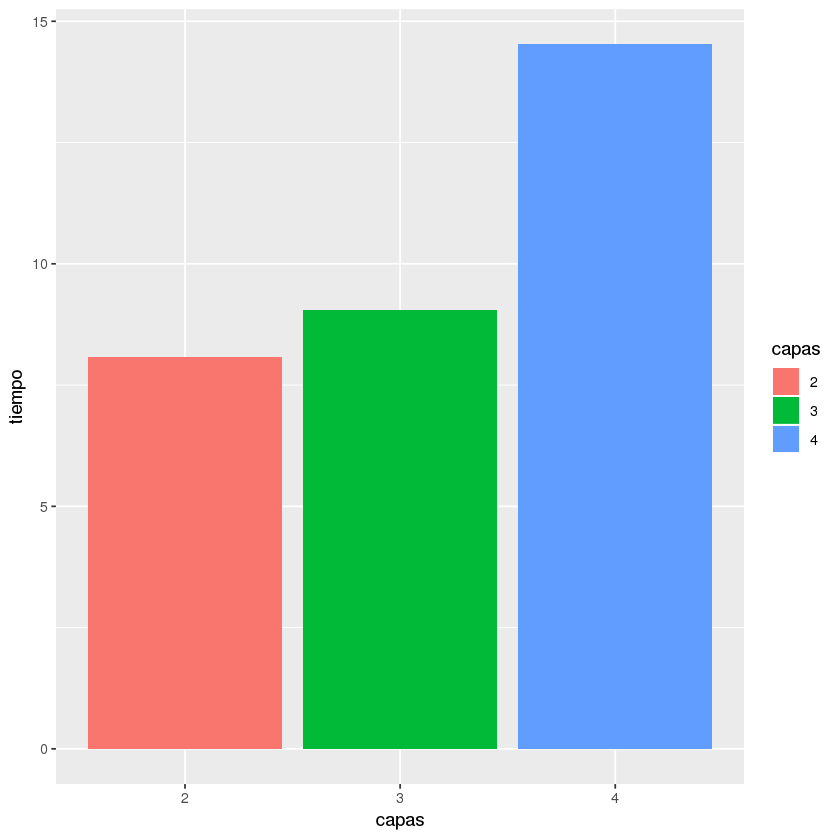

In [26]:
dfm.complejidad.tiempo <- data.frame(tiempo = c(nn1LFit1000Iter$times$final[1], nn2LFit1300Iter$times$final[1],
nn3LFit1750Iter$times$final[1]), capas = factor(c('2','3','4')))
ggplot(dfm.complejidad.tiempo, aes(x=capas,y=tiempo,fill=capas)) + geom_col()

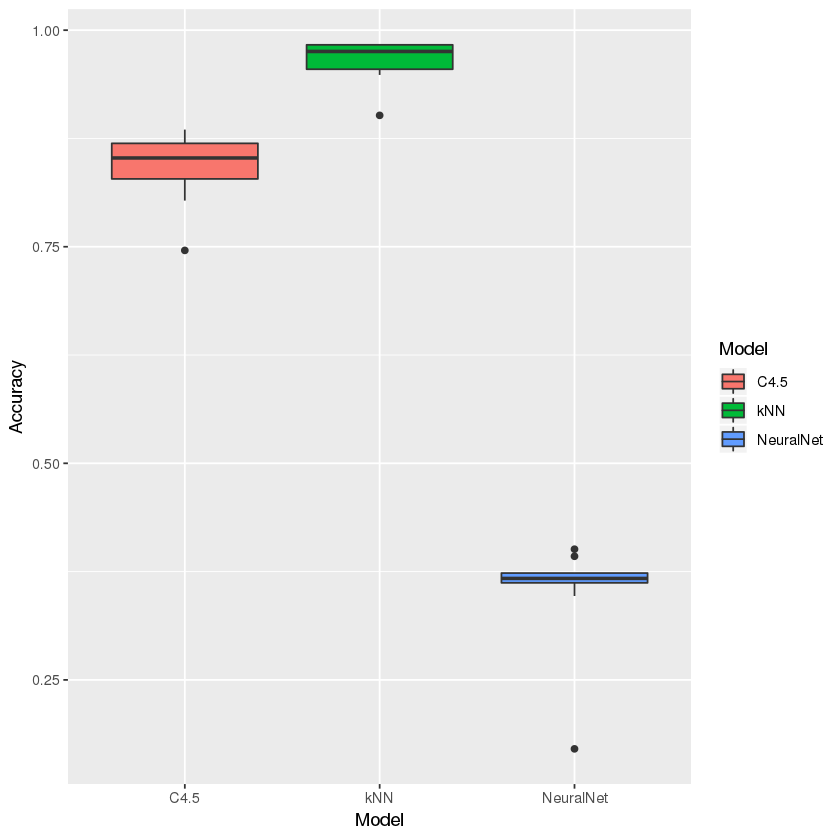

In [28]:
dfm.resamp <- data.frame(Accuracy = c(nn1LFit1000Iter$resample$Accuracy, j48Fit$resample$Accuracy,
knnFitTraining$resample$Accuracy),
Model = rep(c('NeuralNet','C4.5','kNN'),each=10))
ggplot(dfm.resamp,aes(x=Model, y=Accuracy, fill=Model)) + geom_boxplot()

In [29]:
t.test(nn1LFit1000Iter$resample$Accuracy,knnFitTraining$resample$Accuracy,paired = T)


	Paired t-test

data:  nn1LFit1000Iter$resample$Accuracy and knnFitTraining$resample$Accuracy
t = -27.053, df = 9, p-value = 6.24e-10
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.6648237 -0.5622199
sample estimates:
mean of the differences 
             -0.6135218 


In [30]:
t.test(nn1LFit1000Iter$resample$Accuracy,j48Fit$resample$Accuracy,paired = T)


	Paired t-test

data:  nn1LFit1000Iter$resample$Accuracy and j48Fit$resample$Accuracy
t = -19.414, df = 9, p-value = 1.18e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.5472167 -0.4329999
sample estimates:
mean of the differences 
             -0.4901083 


In [31]:
binom.test(round(c(0.4848485,1-0.4848485)*nrow(testing)),p = 0.4292929)


	Exact binomial test

data:  round(c(0.4848485, 1 - 0.4848485) * nrow(testing))
number of successes = 96, number of trials = 199, p-value = 0.1331
alternative hypothesis: true probability of success is not equal to 0.4292929
95 percent confidence interval:
 0.4111959 0.5541600
sample estimates:
probability of success 
             0.4824121 


## Máquinas vector soporte

In [35]:
ctrl <- trainControl( method = "cv")
set.seed(236856)
svmLinealDuroFit <- train(
    Class ~ .,
    data = training,
    method = "svmLinear",
    trControl = ctrl,
    tuneGrid = data.frame(C=100),
    scale = FALSE
)

In [36]:
svmLinealDuroFit$results[,2:3]

Accuracy,Kappa
0.9799917,0.9735754


In [39]:
svmLinealDuroFit$finalModel@alphaindex[[1]]

[1]   3  24  27  76 140 192 194 260 269 272 279 286 288 289 349 353 388 407 413
[20] 455 460 463 472 474 562 563 566 600

In [41]:
w <- colSums(svmLinealDuroFit$finalModel@coef[[1]] *
               training[svmLinealDuroFit$finalModel@alphaindex[[1]],1:2])
w

gene_12382   gene_8057 
 0.00000000 -0.02573557

In [45]:
set.seed(236856) 
svmLinealBlandoFit <- train(
    Class ~ .,
    data = training,
    method = "svmLinear", trControl = ctrl,
    tuneGrid = data.frame(C=1),
      scale = FALSE
)

Warning message in data.frame(intercept = intercept, slope = slope):
“row names were found from a short variable and have been discarded”Warning message in data.frame(intercept = intercept, slope = slope):
“row names were found from a short variable and have been discarded”Warning message in data.frame(intercept = intercept, slope = slope):
“row names were found from a short variable and have been discarded”ERROR while rich displaying an object: Error in FUN(X[[i]], ...): objeto 'set' no encontrado

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(ret

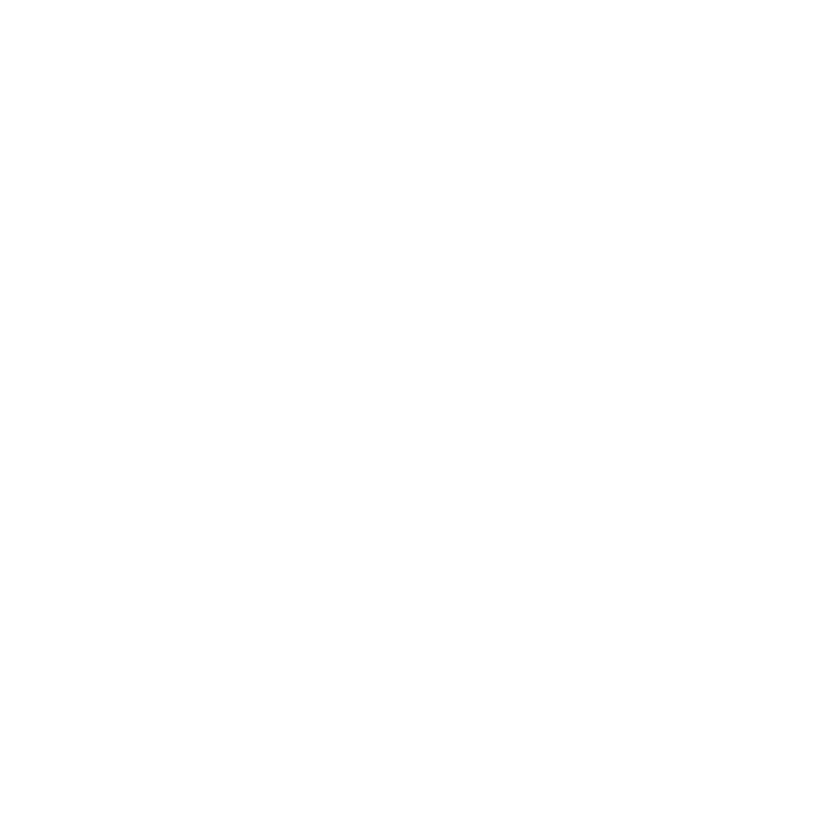

In [48]:
w <- colSums(svmLinealBlandoFit$finalModel@coef[[1]] * training[svmLinealBlandoFit$finalModel@alphaindex[[1]],1:2])
b <- svmLinealBlandoFit$finalModel@b
svmPlot <- ggplot(tcga.filtered) +
geom_abline(slope = -w[1]/w[2], intercept = b/w[2]) +
geom_abline(slope = -w[1]/w[2], intercept = (b+1)/w[2], linetype = 2) + geom_abline(slope = -w[1]/w[2], intercept = (b-1)/w[2], linetype = 2)

for(idx in svmLinealBlandoFit$finalModel@alphaindex[[1]]){
    svmPlot <- svmPlot + annotate("rect", xmin = training[idx,1]-0.1, xmax = training[idx,1]+0.1,
        ymin = training[idx,2]-0.1, ymax = training[idx,2]+0.1, alpha = .4) 
}

svmPlot + geom_point(aes(x=X1,y=X2,color=Class, shape = set), alpha=0.7)
    
    
    

In [59]:
head(tcga.filtered)

gene_12382,gene_8057,gene_3787,gene_2160,gene_8570,gene_4382,gene_17560,gene_14235,gene_13011,gene_15132,⋯,gene_2156,gene_9361,gene_17324,gene_20408,gene_12380,gene_14946,gene_14994,gene_8981,gene_17533,Class
0,9.223816,9.934118,7.416983,5.634797,4.827128,0.5918709,0,4.511449,6.559441,⋯,4.355777,0.0000000,0.0000000,6.075477,0.5918709,13.27560,8.869082,9.359207,2.824951,PRAD
0,8.648091,9.699633,8.499599,1.590818,7.388103,1.0043935,0,2.006585,7.346319,⋯,5.384385,0.0000000,0.3236583,5.803031,0.0000000,13.52978,8.978141,5.835166,5.608505,LUAD
0,9.183333,9.728832,8.250957,5.376231,3.976345,0.4525954,0,2.228018,6.640336,⋯,6.862092,0.0000000,0.0000000,5.983573,0.0000000,13.30788,8.412574,10.781515,3.796733,PRAD
0,9.130174,9.352198,8.414393,4.933119,6.128269,0.0000000,0,3.573556,6.355998,⋯,6.292150,0.0000000,0.4348817,7.023555,0.0000000,13.03412,8.979462,13.573434,2.478532,PRAD
0,9.070676,9.687939,8.798692,2.801097,6.065038,4.9603681,0,6.034081,7.276832,⋯,5.502560,0.6493855,0.0000000,5.861429,0.0000000,13.80710,9.804430,11.136728,4.304657,BRCA
0,8.648077,9.610272,9.036885,4.149373,4.853447,1.6538855,0,7.057948,6.734303,⋯,5.400569,2.1489341,0.0000000,5.355133,0.0000000,13.35543,8.258712,10.392393,4.149373,PRAD


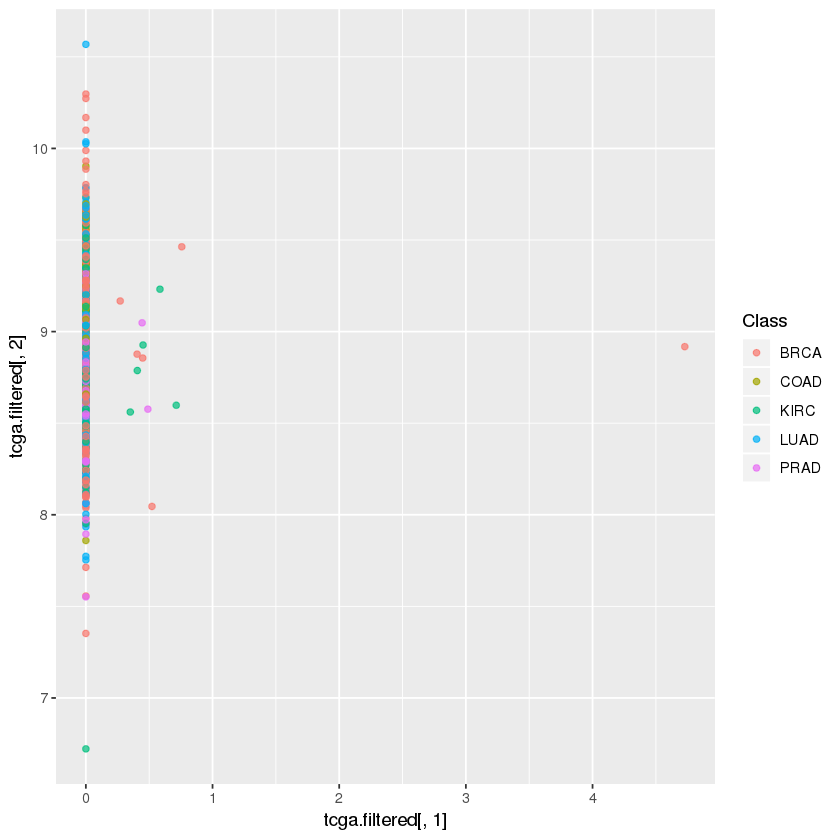

In [63]:
ggplot(tcga.filtered) + geom_point(aes(x=tcga.filtered[,1],y=tcga.filtered[,2],color=Class), alpha = 0.7)